- Phạm Hoàn Phúc 52000704
- Nguyễn Hoài Nam 52000688
- Ngô Văn Danh 52100877

## Bài toán classification dự đoán số tuổi của bào ngư
Thông tin dataset: 
- 4177 instance
- 9 feature
- Loại dữ liệu: Categorical, Numerical

In [1]:
#import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import tensorflow as tf

### Reading data

In [2]:
#đọc data
filename = 'abalone.data'
data = pd.read_csv(filename)
data.head(4)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10


### Mô tả dữ liệu:
- Sex: M(male), F(female), I(infant)
- Length: Longest shell measurement (mm)
- Diameter: Perpendicular to length (mm)
- Height: With meat in shell (mm)
- Whole_weight: Whole abalone (g)
- Shucked_weight: Weight of meat (g)
- Viscera_weight: Gut weight (after bleeding) (g)
- Shell_weight: After being dried (g)
- Rings (Target): +1.5 gives the age in years

Trong đó Sex là dữ liệu categorical, các feature còn lại có dữ liệu là numerical

In [3]:
data.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

In [4]:
#mô tả dữ liệu
data.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [5]:
#kiểm tra mất mát dữ liệu
data.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

In [6]:
#kiểm tra dữ liệu bị trùng lặp
data.duplicated().sum()

0

In [7]:
#mô tả biến mục tiêu
data['Rings'].describe()

count    4177.000000
mean        9.933684
std         3.224169
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: Rings, dtype: float64

### Visualizing dataset

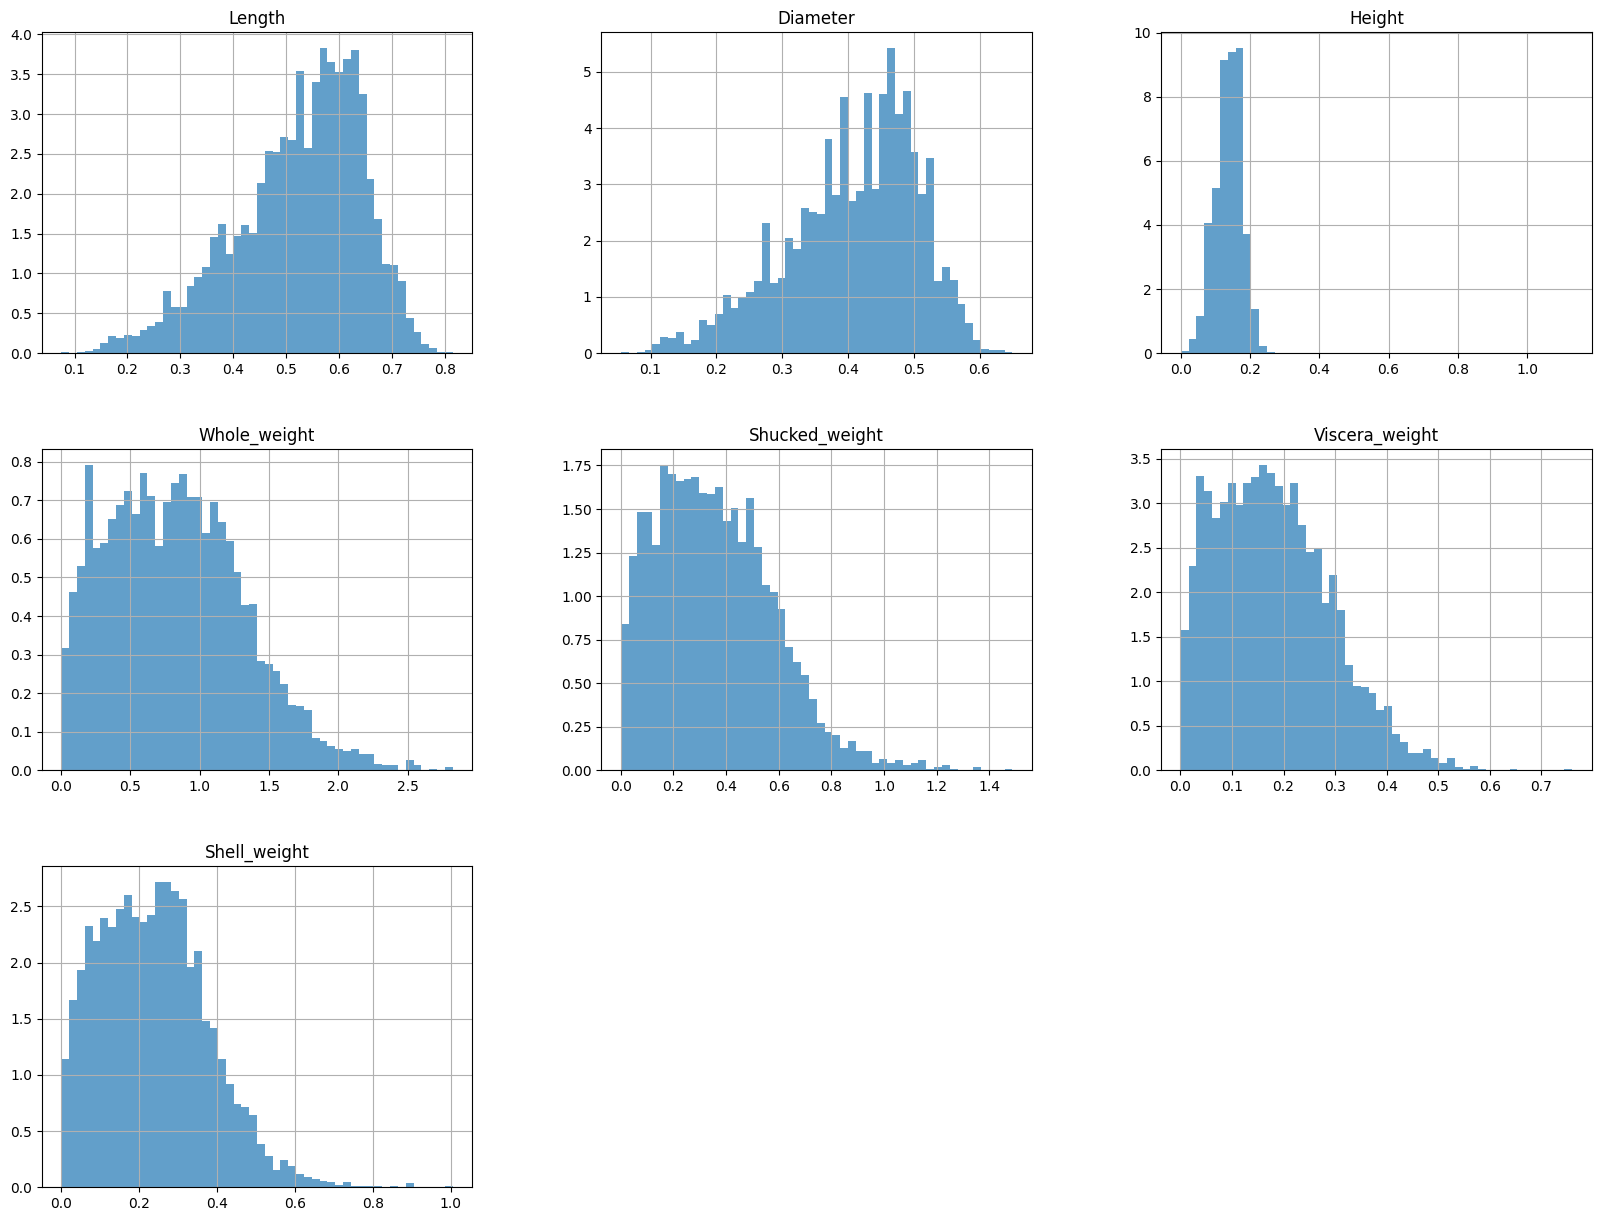

In [8]:
#phân phối của các feature
data.hist(column = ['Length', 'Diameter', 'Height', 'Whole_weight','Shucked_weight','Viscera_weight','Shell_weight'], bins=50, alpha = 0.7,density = 1, figsize=(20, 15))
plt.show()

<Axes: >

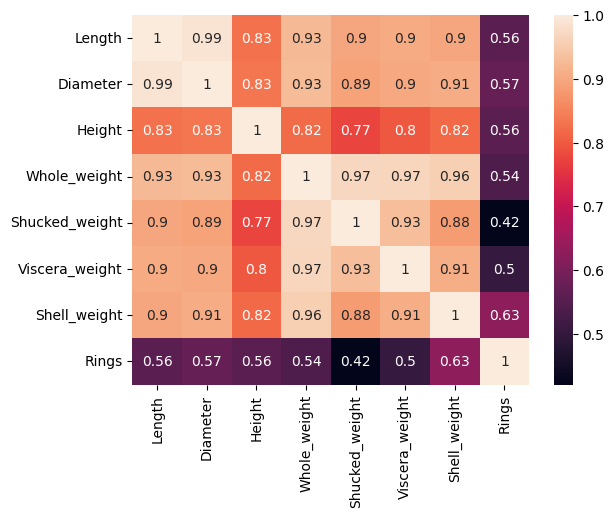

In [9]:
#Phân tích sự tương quan giữa các feature
sns.heatmap(data.corr(numeric_only=True), annot=True)

Có thể thấy Rings có độ tương quan cao nhất với Shell_weight (0.63), các feature khác chênh lệch rất gần nhau lần lược là Diameter (0.57), Length (0.56) và Height (0.56),... và thấp nhất là Sucked_weight (0.42)

Length và Diameter có độ tương quan rất cao với nhau (0.99) => Lượt bỏ một feature do có thể gây ra đa cộng tuyến (multicollinearity)

Whole_weight = Shucked_weight + Viscera_weight + Shell_weight + tạp chất

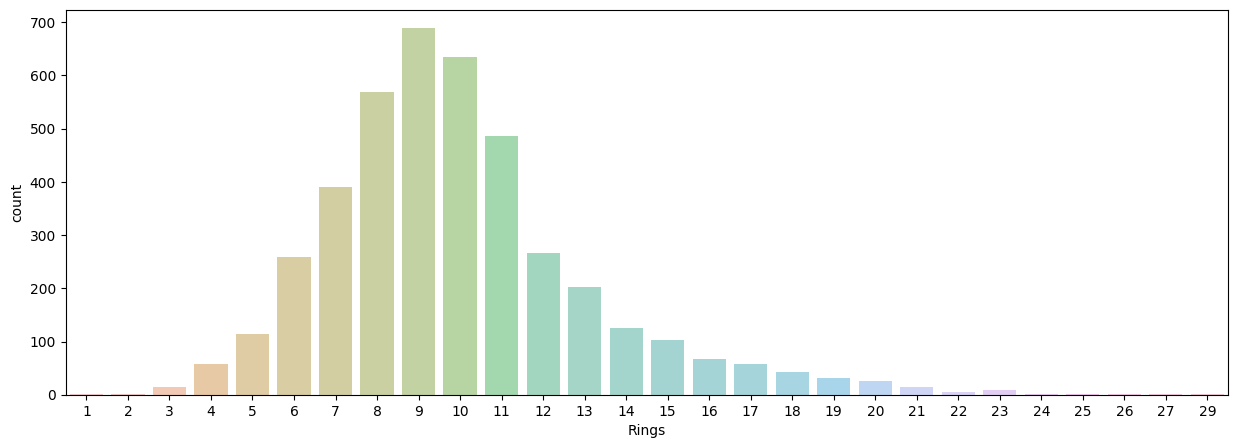

In [10]:
#phân phối của biến mục tiêu (Rings)
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(x='Rings',data=data,alpha=0.5)

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Sex', ylabel='Count'>

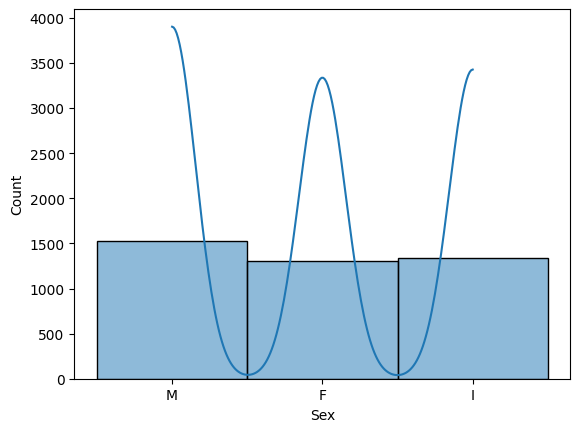

In [11]:
#Phân phối của đặc trưng sex
sns.histplot(data = data['Sex'], kde = True)

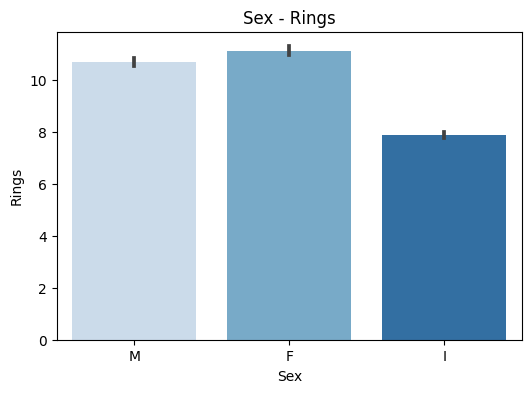

In [12]:
#phân phối giữa giới tính và số vòng
plt.figure(figsize=(6,4))

sns.barplot(x='Sex', y='Rings', data = data, palette='Blues')
plt.title('Sex - Rings')
plt.show()

Có thể thấy bào ngư cái có số vòng cao hơn bào ngư đực và thấp nhất là bào ngư sơ sinh

Giữ lại feature giới tính do nhận thấy feature này góp phần dự đoán số vòng

In [13]:
#Phân loại bào ngư vào 3 nhóm tùy thuộc vào số vòng của chúng
age_label = list()
for rings in data['Rings']:
    if rings < 8:
        age_label.append('Young')
    elif rings >= 8 and rings <= 11:
        age_label.append('Middle-aged')
    else:
        age_label.append('Old')
            
# Cập nhật cột này vào dataset
data = pd.concat([data.reset_index(drop=True), pd.DataFrame(age_label, columns=['Age'])], axis=1)

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

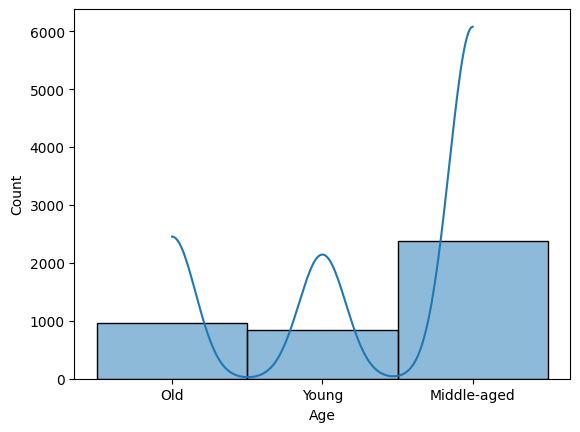

In [14]:
#phân phối giữa nhóm tuổi và số vòng
sns.histplot(data = data['Age'], kde = True)

### Data progressing

In [15]:
#Data transformation
types = data.dtypes
names = list(data.columns)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in range(len(types)):
    if types[i] == 'object':
        le.fit_transform(data[names[i]])
        data[names[i]] = le.transform(data[names[i]])

C:\Users\Admin\AppData\Local\Temp\ipykernel_14708\1531082499.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if types[i] == 'object':
C:\Users\Admin\AppData\Local\Temp\ipykernel_14708\1531082499.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if types[i] == 'object':


### Feature selection

In [16]:
#Phân tách X, y
X = data.drop(['Rings', 'Age'], axis=1)
y = data['Age']

Drop feature Diameter

In [17]:
X_new = X.drop(['Diameter'], axis=1)    

In [18]:
#Data normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_new)
X_scaled = scaler.transform(X_new)

In [19]:
#Chia dataset thành tập train và tập test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

### Dự đoán bằng các mô hình học máy cơ bản

In [20]:
Acc = []
Model = []

#### kNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
#Điều chỉnh các hyper-parameter để tránh overfiting
model = KNeighborsClassifier(n_neighbors=40, weights='distance') 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Acc.append(accuracy_score(y_test, y_pred))
Model.append('kNN')

In [22]:
#Cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation scores: [0.74641148 0.70454545 0.70778443 0.71017964 0.71377246]
Mean CV accuracy: 0.7165386929490302


In [23]:
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7228    0.8942    0.7994       586
           1     0.7383    0.3435    0.4688       230
           2     0.8263    0.7686    0.7964       229

    accuracy                         0.7455      1045
   macro avg     0.7625    0.6687    0.6882      1045
weighted avg     0.7489    0.7455    0.7260      1045



#### Gaussian Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Acc.append(accuracy_score(y_test, y_pred))
Model.append('GaussuanNB')

scores = cross_val_score(model, X_scaled, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation scores: [0.56818182 0.52751196 0.63592814 0.58083832 0.55329341]
Mean CV accuracy: 0.5731507320287654


In [25]:
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.6882    0.5461    0.6089       586
           1     0.3802    0.4348    0.4057       230
           2     0.6341    0.8777    0.7363       229

    accuracy                         0.5943      1045
   macro avg     0.5675    0.6195    0.5836      1045
weighted avg     0.6085    0.5943    0.5921      1045



#### Decision tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5, min_samples_split=15, min_samples_leaf=5) #Điều chỉnh các hyper-parameter để tránh overfiting
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Acc.append(accuracy_score(y_test, y_pred))
Model.append('Decision tree')

In [27]:
#Cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation scores: [0.73923445 0.70574163 0.71736527 0.69580838 0.6754491 ]
Mean CV accuracy: 0.7067197662092084


In [28]:
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7174    0.8447    0.7759       586
           1     0.5987    0.3957    0.4764       230
           2     0.8374    0.7424    0.7870       229

    accuracy                         0.7234      1045
   macro avg     0.7178    0.6609    0.6798      1045
weighted avg     0.7176    0.7234    0.7124      1045



#### SVM

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

model = SVC(kernel='rbf', C=100) #Điều chỉnh các hyper-parameter để tránh overfiting

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Acc.append(accuracy_score(y_test, y_pred))
Model.append('SVM')

In [30]:
#Cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation scores: [0.73923445 0.73325359 0.72095808 0.74850299 0.74251497]
Mean CV accuracy: 0.7368928172363407


In [31]:
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7551    0.8840    0.8145       586
           1     0.7517    0.4870    0.5910       230
           2     0.8429    0.7729    0.8064       229

    accuracy                         0.7722      1045
   macro avg     0.7832    0.7146    0.7373      1045
weighted avg     0.7736    0.7722    0.7635      1045



### Dự đoán bằng các mô hình thuộc Ensemble Learning

#### Bagging: Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=15, min_samples_leaf=5, max_depth=5, random_state=42) #Điều chỉnh các hyper-parameter để tránh overfiting

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Acc.append(accuracy_score(y_test, y_pred))
Model.append('Random Forest')

In [33]:
#Cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation scores: [0.72368421 0.66028708 0.71137725 0.68982036 0.68622754]
Mean CV accuracy: 0.6942792883133255


In [34]:
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.6964    0.9198    0.7926       586
           1     0.7826    0.2348    0.3612       230
           2     0.8218    0.7249    0.7703       229

    accuracy                         0.7263      1045
   macro avg     0.7669    0.6265    0.6414      1045
weighted avg     0.7428    0.7263    0.6928      1045



#### Boosting: Gradient Boosting

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
#Gradient Boosting
model = GradientBoostingClassifier(max_depth=10, learning_rate=0.1, n_estimators=100, random_state=42) #Điều chỉnh các hyper-parameter để tránh overfiting

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Acc.append(accuracy_score(y_test, y_pred))
Model.append('Gradient Boosting')

In [36]:
#Cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation scores: [0.70095694 0.72368421 0.70179641 0.70898204 0.69341317]
Mean CV accuracy: 0.7057665530183652


In [37]:
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7342    0.7918    0.7619       586
           1     0.6000    0.5478    0.5727       230
           2     0.7931    0.7031    0.7454       229

    accuracy                         0.7187      1045
   macro avg     0.7091    0.6809    0.6933      1045
weighted avg     0.7176    0.7187    0.7166      1045



#### Stacking: Random Forest - kNN

In [38]:
from sklearn.ensemble import StackingClassifier

#Stacking với kNN và random forest
models = [('rf', RandomForestClassifier(n_estimators=100,  max_depth=10, random_state=42)),
        ('knc', KNeighborsClassifier(n_neighbors=5))] #Điều chỉnh các hyper-parameter để tránh overfiting

stacking_model = StackingClassifier(estimators=models)
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
Acc.append(accuracy_score(y_test, y_pred))
Model.append('Stacking')

In [39]:
#Cross-validation
scores = cross_val_score(stacking_model, X_scaled, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation scores: [0.76196172 0.70574163 0.71497006 0.72694611 0.72095808]
Mean CV accuracy: 0.7261155201558604


In [40]:
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7493    0.8567    0.7994       586
           1     0.6647    0.5000    0.5707       230
           2     0.8515    0.7511    0.7981       229

    accuracy                         0.7550      1045
   macro avg     0.7552    0.7026    0.7227      1045
weighted avg     0.7531    0.7550    0.7488      1045



### Feed Forward Neural Network 

In [41]:
from tensorflow.keras.utils import to_categorical
y_t = y_train
y_train = to_categorical(y_train)
print(y_train[:5])

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [42]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3,activation='softmax'))

In [43]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
#Định nghĩa early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='accuracy', patience=30, restore_best_weights=True)

In [45]:
history1 = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5346 - loss: 0.9880
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5802 - loss: 0.8902
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5966 - loss: 0.8307
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6457 - loss: 0.7790
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6503 - loss: 0.7648
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6366 - loss: 0.7544
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6386 - loss: 0.7718
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6452 - loss: 0.7487
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6770 - loss: 0.7112
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6733 - loss: 0.7285
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6757 - loss: 0.7202
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)                │        512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 32)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 3)                 │         99 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 8,075 (31.55 KB)

 Trainable params: 2,691 (10.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,384 (21.04 KB)

In [47]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
Acc.append(accuracy_score(y_test, y_pred))
Model.append('NN')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [48]:
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7656    0.8191    0.7914       586
           1     0.6335    0.6087    0.6208       230
           2     0.8629    0.7424    0.7981       229

    accuracy                         0.7560      1045
   macro avg     0.7540    0.7234    0.7368      1045
weighted avg     0.7578    0.7560    0.7553      1045



### Reccurent Neural Network 

In [49]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(3132, 7, 1)


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM

model = Sequential()
model.add(Input(shape = (X_train.shape[1], 1)))
model.add(SimpleRNN(units = 64, return_sequences = True))
model.add(Dropout(0.3))  # Thêm dropout để ngừa overfitting
model.add(SimpleRNN(units = 64))
model.add(Dropout(0.3))  # Thêm dropout để ngừa overfitting
model.add(Dense(units=3, activation='softmax')) 

In [51]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
early_stopping = EarlyStopping(monitor='accuracy', patience=30, restore_best_weights=True)

In [53]:
history2 = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5604 - loss: 0.9172
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6416 - loss: 0.7554
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6559 - loss: 0.7440
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6479 - loss: 0.7480
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6491 - loss: 0.7451
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6530 - loss: 0.7206
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6598 - loss: 0.7299
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6637 - loss: 0.7177
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6697 - loss: 0.7120
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6794 - loss: 0.7082
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6951 - loss: 0.6967
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 7, 64)             │      4,224 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 64)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 3)                 │        195 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 38,027 (148.55 KB)

 Trainable params: 12,675 (49.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,352 (99.04 KB)

In [55]:
y_pred = model.predict(X_test)
print(y_pred)
y_pred = y_pred.argmax(axis=1)
Acc.append(accuracy_score(y_test, y_pred))
Model.append('RNN')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[4.6426773e-01 5.3173023e-01 4.0020468e-03]
 [7.8210521e-01 1.8852156e-01 2.9373227e-02]
 [9.8765895e-02 9.0094775e-01 2.8637002e-04]
 ...
 [5.9333235e-01 4.0452656e-01 2.1410869e-03]
 [4.5704988e-01 5.1872128e-01 2.4228849e-02]
 [7.5993079e-01 1.7880289e-01 6.1266288e-02]]


In [56]:
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7695    0.8430    0.8046       586
           1     0.6806    0.5652    0.6176       230
           2     0.8349    0.7729    0.8027       229

    accuracy                         0.7665      1045
   macro avg     0.7617    0.7270    0.7416      1045
weighted avg     0.7643    0.7665    0.7630      1045



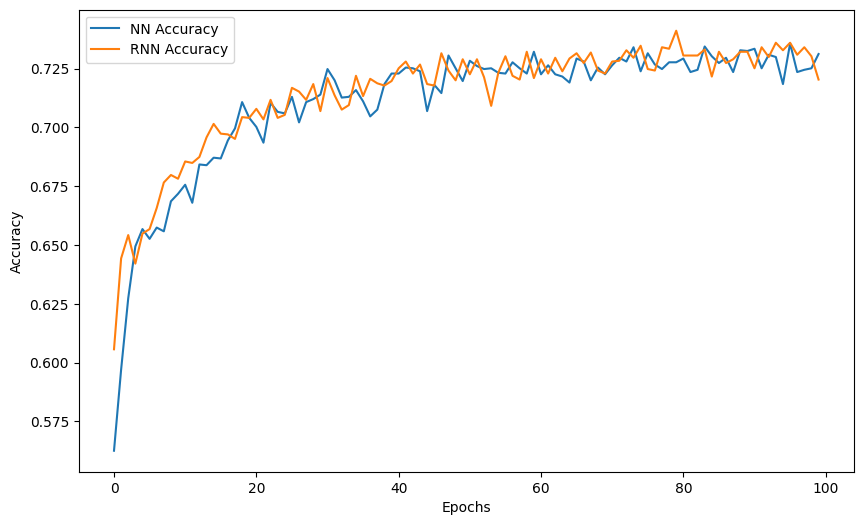

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(history1.history['accuracy'], label='NN Accuracy', linestyle='solid')
plt.plot(history2.history['accuracy'], label='RNN Accuracy', linestyle='solid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluation

[Text(0, 0, '0.745455'),
 Text(0, 0, '0.594258'),
 Text(0, 0, '0.723445'),
 Text(0, 0, '0.772249'),
 Text(0, 0, '0.726316'),
 Text(0, 0, '0.71866'),
 Text(0, 0, '0.755024'),
 Text(0, 0, '0.755981'),
 Text(0, 0, '0.766507')]

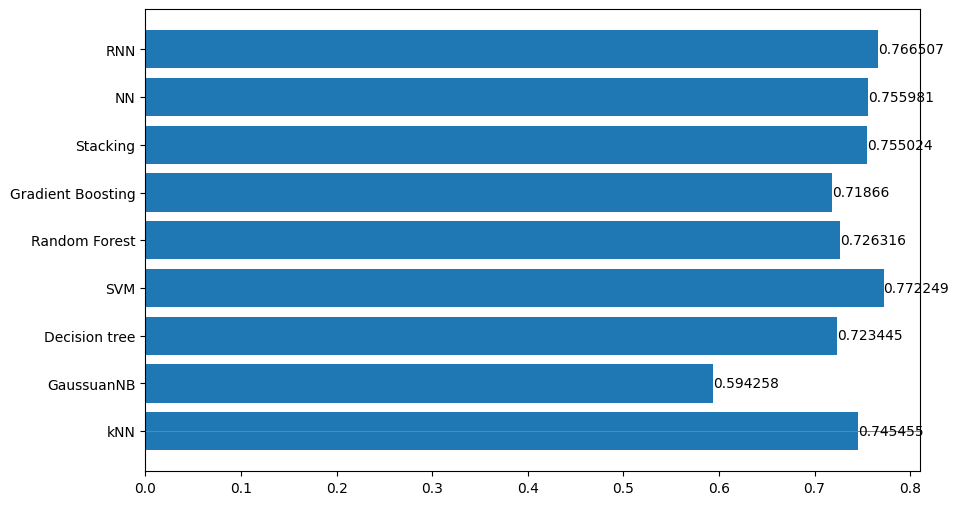

In [58]:
df = pd.DataFrame({'Accuracy' : Acc}, index=Model)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(df.index, df['Accuracy'])
ax.axhline(0, color='grey', linewidth=0.7)
ax.bar_label(ax.containers[0])

### Một số phương pháp để cải thiện độ chính xác cho mô hình:

#### Thu thập dữ liệu
Đảm bảo rằng dữ liệu mà mô hình của bạn được huấn luyện trên là đa dạng và đủ biểu diễn cho các trường hợp có thể xuất hiện trong ứng dụng thực tế giúp cho mô hình đưa ra những dự đoán chính xác hơn.
#### Tiền xử lý dữ liệu
Loại bỏ dữ liệu nhiễu, xử lý giữ liệu thiếu, chuẩn hóa dữ liệu để giảm ảnh hưởng của các giá trị ngoại lệ và làm tăng tính ổn định của mô hình.
#### Tinh chỉnh các siêu tham số 
Điều chỉnh các tham số như số k gần nhất trong mô hình kNN, kích thước batch, số lớp và đơn vị ẩn để tối ưu hóa hiệu suất của mô hình.
#### Giảm chiều dữ liệu
Sử dụng phương pháp như feature selection để giảm chiều dữ liệu, loại bỏ đi các đặc trưng không cần thiết, đặc biệt là khi bạn đang làm việc với các tập dữ liệu lớn và có số chiều cao.
#### Sử dụng kỹ thuật Ensemble
Kết hợp nhiều mô hình để tạo thành một ensemble có thể giúp cải thiện độ chính xác bằng cách kết hợp sức mạnh của các mô hình khác nhau.